# 손 글씨 숫자 예측 모델 구현
- 손 글씨 0~9 숫자 이미지 데이터를 통해 무슨 숫자인지 예측하는 모델
- 분류 모델

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"

# 라이브러리 로드

In [2]:
from tensorflow.keras.datasets import mnist             # Modified National Institute of Standards and Technology database
import matplotlib.pyplot as plt                         # 시각화를 위한 라이브러리
import numpy as np                                      # 연산 등을 위한 라이브러리
import pandas as pd
import seaborn as sns

from tensorflow.keras.layers import Conv2D, Input, MaxPooling2D, Flatten, Dense, Dropout   # Tensorflow 모델 구성을 위한 라이브러리
from tensorflow.keras.models import Model
import tensorflow as tf

from sklearn.model_selection import train_test_split                                       # 데이터 전처리를 위한 라이브러리
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# 데이터 로드
- X, y : 훈련 데이터  
- X_test, y_test : 최종 성능 테스트 데이터


In [3]:
(X, y), (X_test, y_test) = mnist.load_data()

print('(batch_size, width, height)\n\n')
print('X shape : {}'.format(X.shape))
print('y shape : {}'.format(y.shape))
print('X_test shape : {}'.format(X_test.shape))
print('y_test shape : {}'.format(y_test.shape))


(batch_size, width, height)


X shape : (60000, 28, 28)
y shape : (60000,)
X_test shape : (10000, 28, 28)
y_test shape : (10000,)


# 데이터 분포 확인
- 데이터의 분포가 균일할 수록 모델은 특징을 더 잘 추출하게 된다.
- MNIST의 경우 0~9 숫자 분포에서 큰 차이가 없다.
- 훈련에 사용될 데이터는 총 60000 장
- 성능 테스트에 사용될 데이터는 총 10000 장
- 너비와 높이는 28
- 데이터는 1채널로 흑백 이미지
- 각 픽셀은 0~255 값 만약 3채널의 RGB 컬러이미지면 각 채널별로 R,G,B를 표현하는 픽셀값이 있음.

In [4]:
pd.DataFrame({'number':y})['number'].value_counts().sort_index().to_frame()

,number
0,5923
1,6742
2,5958
3,6131
4,5842
5,5421
6,5918
7,6265
8,5851
9,5949


# (학습, 검증) 데이터 분리
- 학습 데이터만 모델 훈련에 쓸 경우 과적합되어 학습 데이터 이외의 데이터를 테스트할 경우 전혀 다른 결과가 나올 수 있음. 즉, 훈련할 때 보던 데이터만 정확히 맞추는 문제가 발생.
- 검증 데이터를 따로 둠으로써 학습 데이터에만 과적합 되는 것을 방지한다.
- 검증데이터를 만드는 방법은 다양하다. 학습 데이터에서 랜덤으로 10~30% 정도 분리하여 검증 데이터로 만들거나 K개의 Fold로 나누는 K-Fold 방법 등이 있다.

In [5]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# 데이터 시각화
- 0~9가 손글씨로 쓰여 있는것을 알 수 있다.

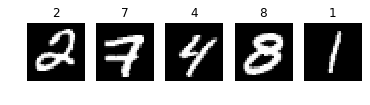

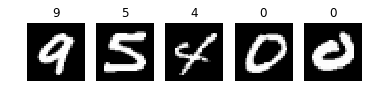

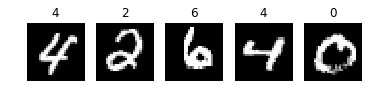

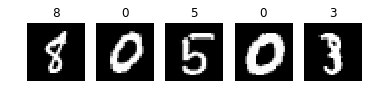

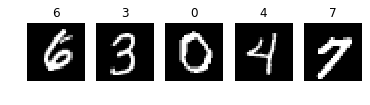

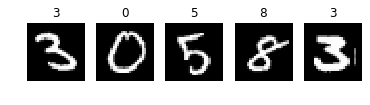

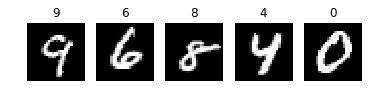

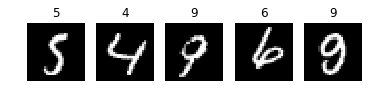

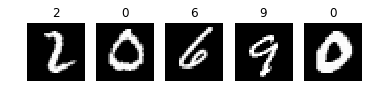

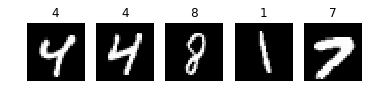

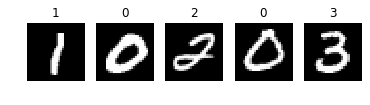

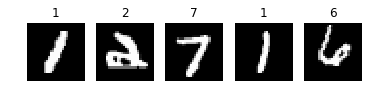

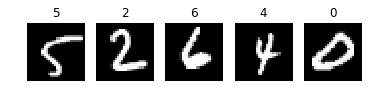

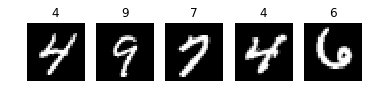

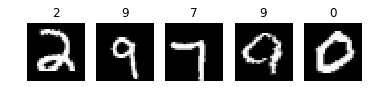

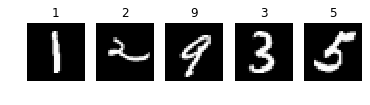

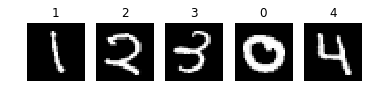

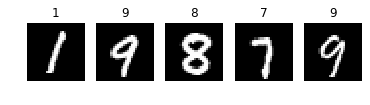

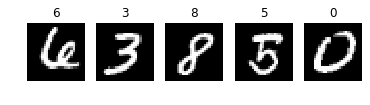

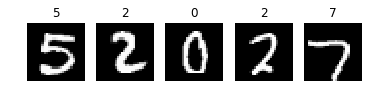

In [6]:
for idx in range(100):
    plt.subplot(1,5,idx%5+1)
    plt.imshow(X_train[idx], cmap='gray')
    plt.title(y_train[idx])
    plt.axis('off')
    if (idx%5+1==5):
        plt.show()

# 데이터 전처리
- 모델이 특징을 잘 추출할 수 있도록 전처리를 해야한다.
- 이미지 데이터의 경우 0\~255의 값을 0~1 값으로 스케일링하는 Min Max Scaling 방법을 사용한다.
- 픽셀들을 255로 나누어주면 된다.

In [7]:
def DataPreprocessing(data):
    data = (data/255.0).astype(np.float32)
    return data
    

## Scaling 전

In [8]:
print(X_train[0][20])

[  0   0   0   0 133 253 248 195  98 190 230 253 253 207  92   0   0   0
   0   0  29  36  21   0   0   0   0   0]


## Scaling 후


In [9]:
X_train = DataPreprocessing(X_train).reshape(-1,28,28,1)
X_valid = DataPreprocessing(X_valid).reshape(-1,28,28,1)
print(X[0][20])

[  0   0   0   0   0   0   0   0   0   0  24 114 221 253 253 253 253 201
  78   0   0   0   0   0   0   0   0   0]


# 합성곱 신경망 딥러닝 모델 생성
- Convolutional Neural Network 2개, Pooling 1개 쌓은것을 총 2번 반복.
- Convolutional Neural Network는 2차원의 이미지에서 지역적 특징을 잘 추출 해낸다.
- 마지막 출력 층 softmax로 0~9의 확률 값을 나타낸다.

In [10]:
def build_model():
    model_input = Input(shape=(28,28,1))
    conv1 = Conv2D(32, 3, activation='relu')(model_input)
    conv1 = Conv2D(64, 3, activation='relu')(conv1)
    pool1 = MaxPooling2D((2,2))(conv1)
    
    conv2 = Conv2D(32, 3, activation='relu')(pool1)
    conv2 = Conv2D(64, 3, activation='relu')(conv2)
    pool2 = MaxPooling2D((2,2))(conv2)
    drop = Dropout(0.3)(pool2)
    
    flat = Flatten()(pool2)
    model_output = Dense(10, activation='softmax')(flat)
    model = Model(model_input, model_output)
    model.summary()
    return model

## 모델 학습시 추가 파라미터 설정
- Batch Size와 epoch(반복횟수)를 설정
- learning rate 를 설정
- 손실 함수와 최적화 함수, 성능평가 metrics에 대해 설정

In [11]:
batch_size=128
epochs=30

decay_st = (len(X_train)//batch_size+1)*epochs
poly_sche = tf.keras.optimizers.schedules.PolynomialDecay(0.001, decay_st, end_learning_rate=1e-6, power=0.9)
opt_poly = tf.keras.optimizers.Adam(poly_sche)


model = build_model()
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt_poly, metrics=['accuracy'])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 32)        18464     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 64)          18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 64)          0     

# 모델 훈련

In [12]:

hist = model.fit(x=X_train, 
          y=y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=batch_size,
          epochs=epochs
      )

Train on 45000 samples, validate on 15000 samples
Epoch 1/30
45000/45000 [==============================] - 4s 93us/sample - loss: 0.2553 - accuracy: 0.9243 - val_loss: 0.0984 - val_accuracy: 0.9700
Epoch 2/30
45000/45000 [==============================] - 2s 54us/sample - loss: 0.0645 - accuracy: 0.9810 - val_loss: 0.0549 - val_accuracy: 0.9831
Epoch 3/30
45000/45000 [==============================] - 2s 55us/sample - loss: 0.0448 - accuracy: 0.9862 - val_loss: 0.0452 - val_accuracy: 0.9859
Epoch 4/30
45000/45000 [==============================] - 2s 54us/sample - loss: 0.0342 - accuracy: 0.9890 - val_loss: 0.0416 - val_accuracy: 0.9873
Epoch 5/30
45000/45000 [==============================] - 2s 54us/sample - loss: 0.0270 - accuracy: 0.9912 - val_loss: 0.0400 - val_accuracy: 0.9883
Epoch 6/30
45000/45000 [==============================] - 2s 54us/sample - loss: 0.0210 - accuracy: 0.9937 - val_loss: 0.0404 - val_accuracy: 0.9884
Epoch 7/30
45000/45000 [==============================] 

# 모델 검증

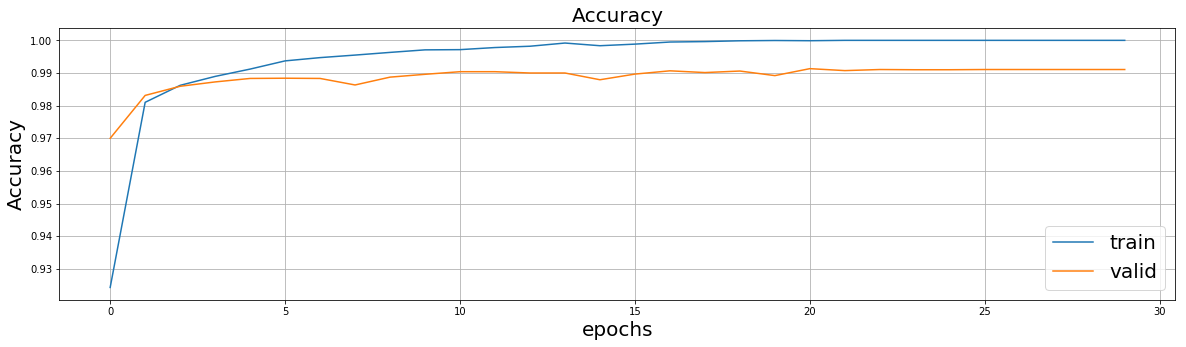

In [13]:
plt.figure(figsize=(20,5))
plt.plot(hist.history['accuracy'], label='train')
plt.plot(hist.history['val_accuracy'], label='valid')
plt.legend(fontsize=20)
plt.xlabel('epochs',size=20)
plt.ylabel('Accuracy',size=20)
plt.title('Accuracy',size=20)
plt.grid()
plt.show()

In [14]:
valid_pred = model.predict(X_valid)
valid_pred = valid_pred.argmax(1)

## 오차행렬 확인

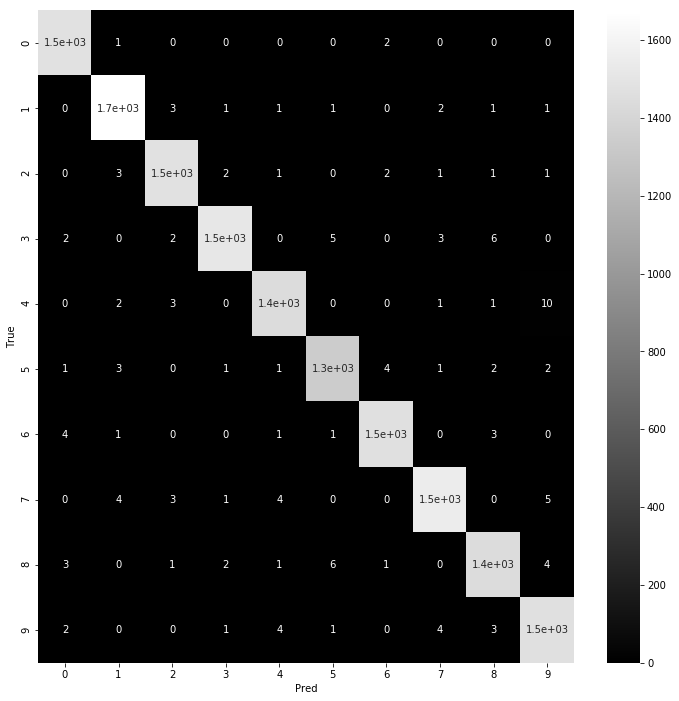

In [15]:
plt.figure(figsize=(12,12))
sns.heatmap(confusion_matrix(y_valid, valid_pred), annot=True, cmap='gray')
plt.xlabel('Pred')
plt.ylabel('True')
plt.show()

In [16]:
check_idx = (y_valid!=valid_pred)

## 예측이 틀린 데이터 확인

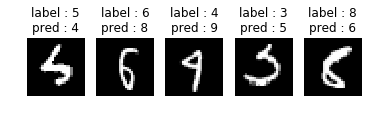

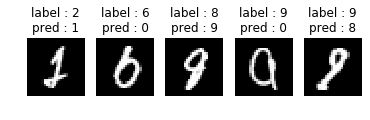

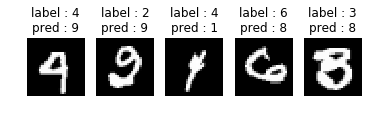

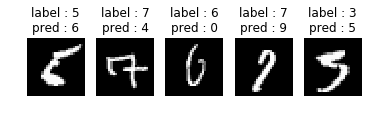

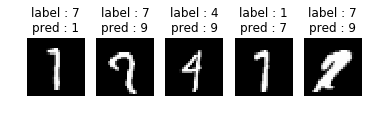

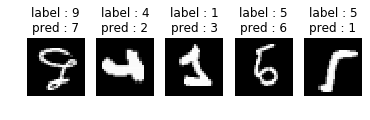

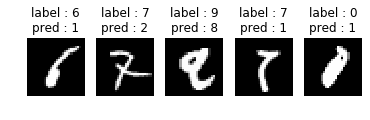

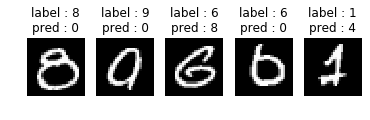

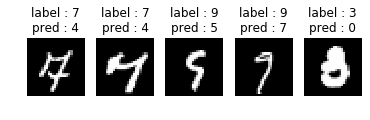

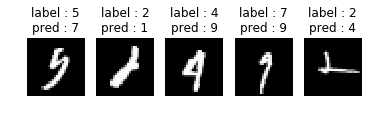

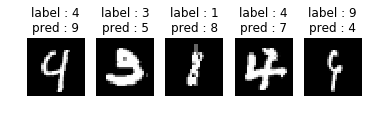

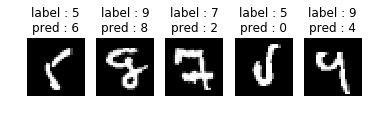

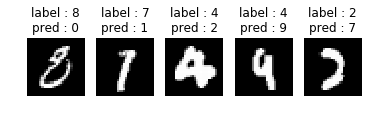

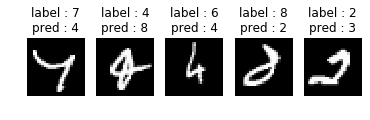

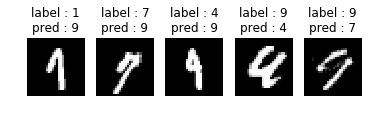

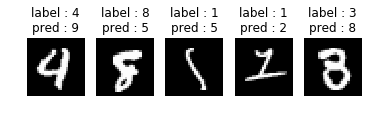

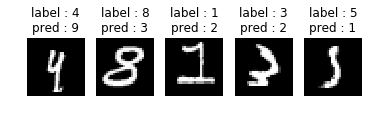

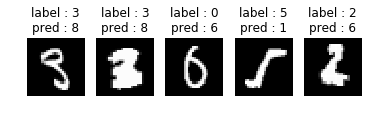

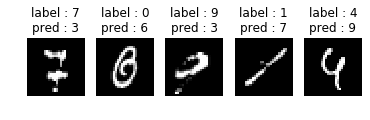

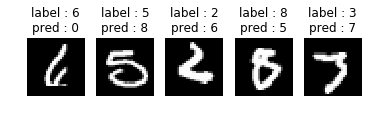

In [17]:
for idx in range(100):
    plt.subplot(1,5,idx%5+1)
    plt.imshow(X_valid[check_idx][idx].reshape(28,28), cmap='gray')
    plt.title('label : {}\npred : {}'.format(y_valid[check_idx][idx], valid_pred[check_idx][idx]))
    plt.axis('off')
    if (idx%5+1==5):
        plt.show()

# 최종 성능 테스트
- 훈련 데이터와 똑같은 방법으로 데이터 전처리 과정을 진행한 뒤 예측을 한다.

In [18]:
X_test = DataPreprocessing(X_test).reshape(-1,28,28,1)


In [19]:
_, accuracy = model.evaluate(X_test, y_test)
print("테스트 세트의 정확도 : {:.3f} %".format(accuracy*100))

10000/10000 [==============================] - 1s 94us/sample - loss: 0.0469 - accuracy: 0.9927
테스트 세트의 정확도 : 99.270 %


In [22]:
from PIL import Image
f = Image.open('6.png')
f = np.array(f)[:,:,0]
f = 255-f
f = DataPreprocessing(f).reshape(-1,28,28,1)

In [23]:
model.predict(f).argmax()

6